# Grover's Search
Grover's Search algorithm about finding the correct answer in a large undosrted space. It uses what's called an "oracle" - a function that doesn't know the answer explicitly, but can only verify whether a guess is right or wrong. 

To understand how this works, imagine you're trying to guess my favorite number. between 1 to 100. It might be 27, but you'd have to ask many times (i.e., submit many guesses) before you find the correct answer. Every wrong answer would be "No", but the right answer would be "Yes".

In a typical range of N numbers, you'd have to ask on average N/2 times to get the correct answer. With Grover's search, that time is cut down to √N times — so 100 possible answers are searched within just 10 guesses.

Grover's search does this search and selection by applying a negative phase to the correct answer, then amplifying that answer through multiple function runs. So if you gave all the possible answers to the algorithm, it would return 1, 2, 3... etc. as normal, but return 27 as -27. 

Depending on how you design the algorithm (specifically, how many repetitions), it would return a graph showing the probability of the correct answer as quite high, and of other wrong answers as quite low. Note that the correct answer may actually be two different answers, as we'll see in a bit.

The steps, in order:
1. Create an equal superposition of all the elements.
2. Flip the sign of the correct solution.
3. Amplify the correct solution by applying the Grover operator.

# Example: The Inheritance Problem

To see this example in action, let's start with the inheritance problem. The inheritance problem posits that there's a certain number of assets with defined values that need to be split between two brothers equally. We'll assume there are 6 assets, each with various asset values equalling $48k in total:

`property prices = [4, 8, 6, 3, 12, 15]`

The goal is for each brother to get $24k each, and we want to find the optimum distribution of the six assets — three for each one.

Now, classically, we might guess what the answer to this is. Maybe we try different combinations until we find the answer. This is trivial when there's a small number of assets (six in this case), but quickly becomes unfeasible when there's a large number of not just assets but also possible combinations we could split the assets in. That's where Grover's search comes in handy.

To help solve this problem, we'll have six binary variables (for each of the six properties) with the following attributes:
- x_i = 0 if the i-th property goes to the first sibling
- x_i = 1 if the i-th property foes to the second sibling.

Steps:
1. We create a superposition of all possible asset allocations.
2. Through the oracle, we mark those distributions that satisfy the request of an equal split.
3. We amplify the probability of observing solution states through Grover's operator.

In [21]:
import pennylane as qml
from pennylane import numpy as np
import numpy

property_prices = [4, 8, 6, 3, 12, 15] # 48 in total

variables_wires = [0, 1, 2, 3, 4, 5] # For each of the assets
aux_oracle_wires = [6, 7, 8, 9, 10, 11] # For the auxiliary qubits needed for the oracle


We're now going to define the oracle. The oracle uses the Fourier Transform (we won't go into the math here) to find the correct split. The basic logic is as follows:

1. If the first wire is 1, add a '4' to the auxilliary bit. If the next one is also 1, add an 8. And so on. 
2. When the total is 24 (i.e., 48 / 2) for the second sibling, flip the sign.

Photo credit: Guillermo Alonso/Pennylane © 2023

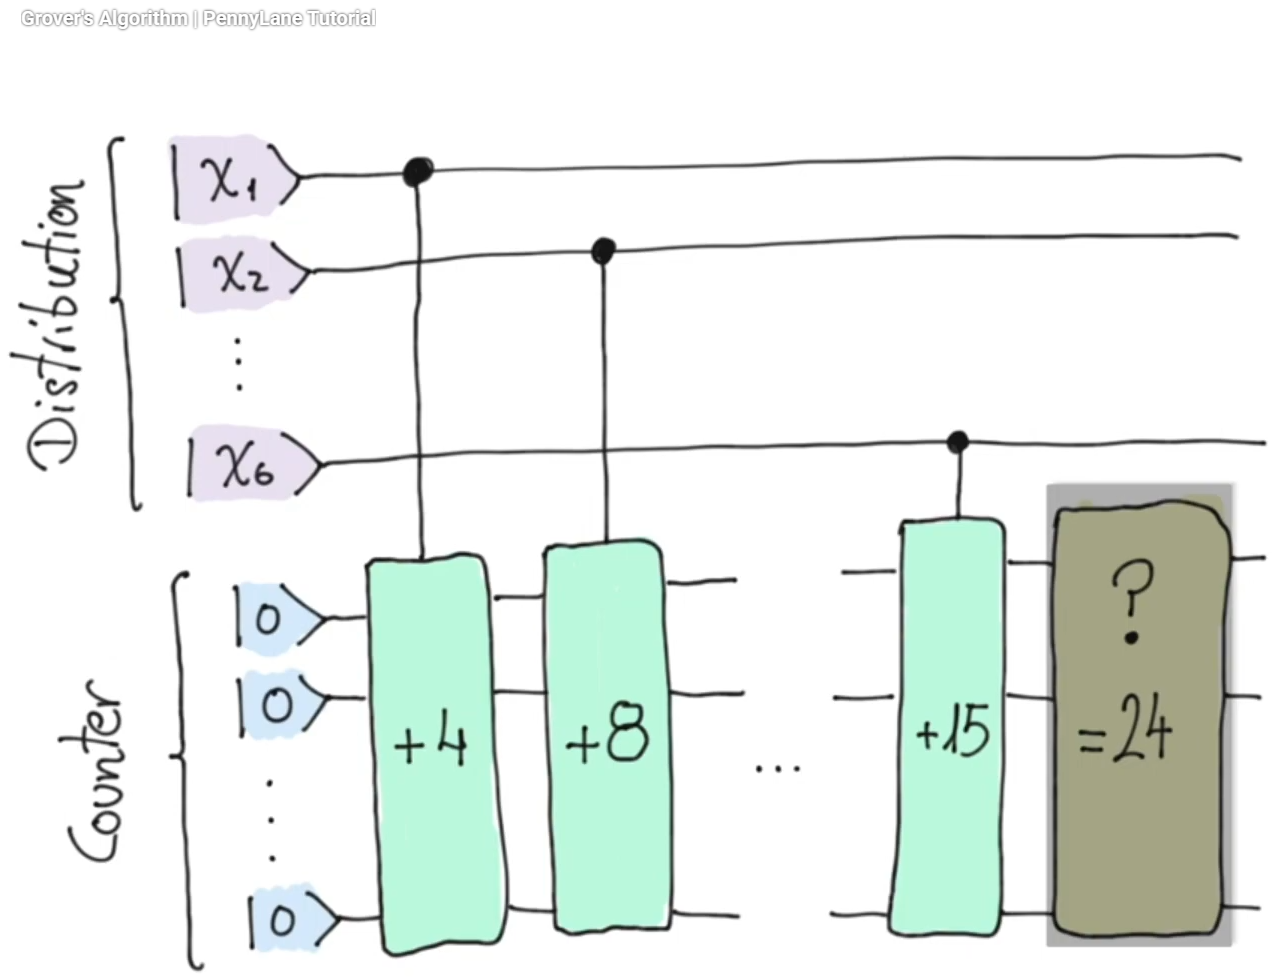

In [22]:
def oracle():
    '''Oracle that marks the states where the sum of selected property prices is 24.'''
    # Now for the oracle logic
    def add_k_fourier(k, wires):
        for j in range(len(wires)):
            qml.RZ(k * np.pi / (2 ** j), wires=wires[j])

    def value_second_sibling():
        qml.QFT(wires=aux_oracle_wires)
        for wire in variables_wires:
            qml.ctrl(add_k_fourier, control=wire)(
                property_prices[wire], 
                aux_oracle_wires
            )
        qml.adjoint(qml.QFT)(wires=aux_oracle_wires)

    value_second_sibling()
    # Now we flip the sign of the amplitude if the sum is 24
    qml.FlipSign(
        sum(property_prices) // 2,
        wires=aux_oracle_wires
    )

    qml.adjoint(value_second_sibling)()

We can now create the Pennylane device (remember: the device is the backend, in this case a simulator, that will run the algorithm). We'll thereafter create the circuit (Starting with the decorator wrapper that binds the device to the code).

In [89]:
dev = qml.device("default.qubit", wires=variables_wires + aux_oracle_wires)

@qml.qnode(dev)
def circuit():
    # Step 1: Initialize the variable qubits in equal superposition
    for wire in variables_wires:
        qml.Hadamard(wires=wire)

    # Step 2: Run the oracle a certain number of times - ideally ~sqrt(N/M)
    for _ in range(3):
    # oracle(variables_wires, aux_oracle_wires)
        oracle()

    # Step 3: Grover Diffusion Operator, stlll within the loop
        qml.GroverOperator(wires=variables_wires)

    return qml.probs(wires=variables_wires)
    #return qml.sample(wires=variables_wires)

circuit = qml.set_shots(circuit, shots=10)



To see the solution, we plot it using matplotlib:

<BarContainer object of 64 artists>

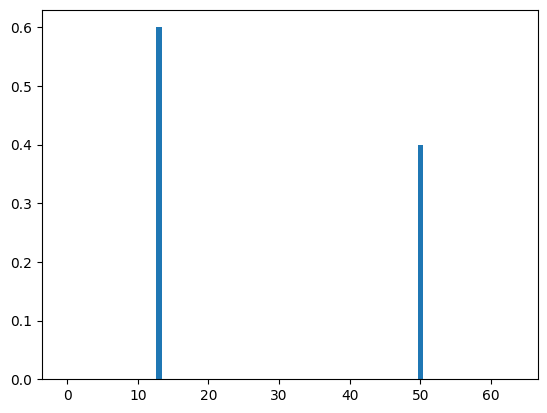

In [90]:
import matplotlib.pyplot as plt

values = circuit()
plt.bar(range(len(values)), values)

This immediately shows there are two clear solutions to our problem — in other words, two possible ways to split the assets equally. We can tease out what the solution is by printing out the values arrived at by running the circuit. These values will correspond to the `variable_wires` array we created earlier, specifically to the index of the asset that should be included in a split to any one brother. For this, we have to replace the return line with `qml.sample` instead of `qml.probs` (I ran into an error trying to mix the two).

In [101]:
dev = qml.device("default.qubit", wires=variables_wires + aux_oracle_wires)

@qml.qnode(dev)
def circuit():
    # Step 1: Initialize the variable qubits in equal superposition
    for wire in variables_wires:
        qml.Hadamard(wires=wire)

    # Step 2: Run the oracle a certain number of times - ideally ~sqrt(N/M)
    for _ in range(3):
    # oracle(variables_wires, aux_oracle_wires)
        oracle()

    # Step 3: Grover Diffusion Operator, stlll within the loop
        qml.GroverOperator(wires=variables_wires)

    #return qml.probs(wires=variables_wires)
    return qml.sample(wires=variables_wires)

circuit = qml.set_shots(circuit, shots=10)

samples = circuit()
print(f"{samples[0]}\n{samples[1]}")         # one bitstring like the video


[1 1 0 0 1 0]
[0 0 1 1 0 1]


And there you have it: two arrays representing the two different possible _solutions_. 

In plain English, each array reads as: "For an equal split, give one brother the assets marked 1 in this array, corresponding to the location of the assets in the original array." 

If you recall, the original asset array was as follows:

`property_prices = [4, 8, 6, 3, 12, 15]` # 48 in total